In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = "bold"
plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline


In [3]:
from scipy.stats import chi2_contingency

In [4]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- Avg age of population is 43yrs
- 


Remove Unwanted columns

In [7]:
df.drop("id", axis = 1, inplace=True)

In [8]:
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns

In [9]:
num_cols

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

In [10]:
cat_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [11]:
#value_counts in each of cat_cols

for i in cat_cols:
    print(df[i].value_counts())
    print("="*50)

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


## Univariate Analysis of Numerical columns

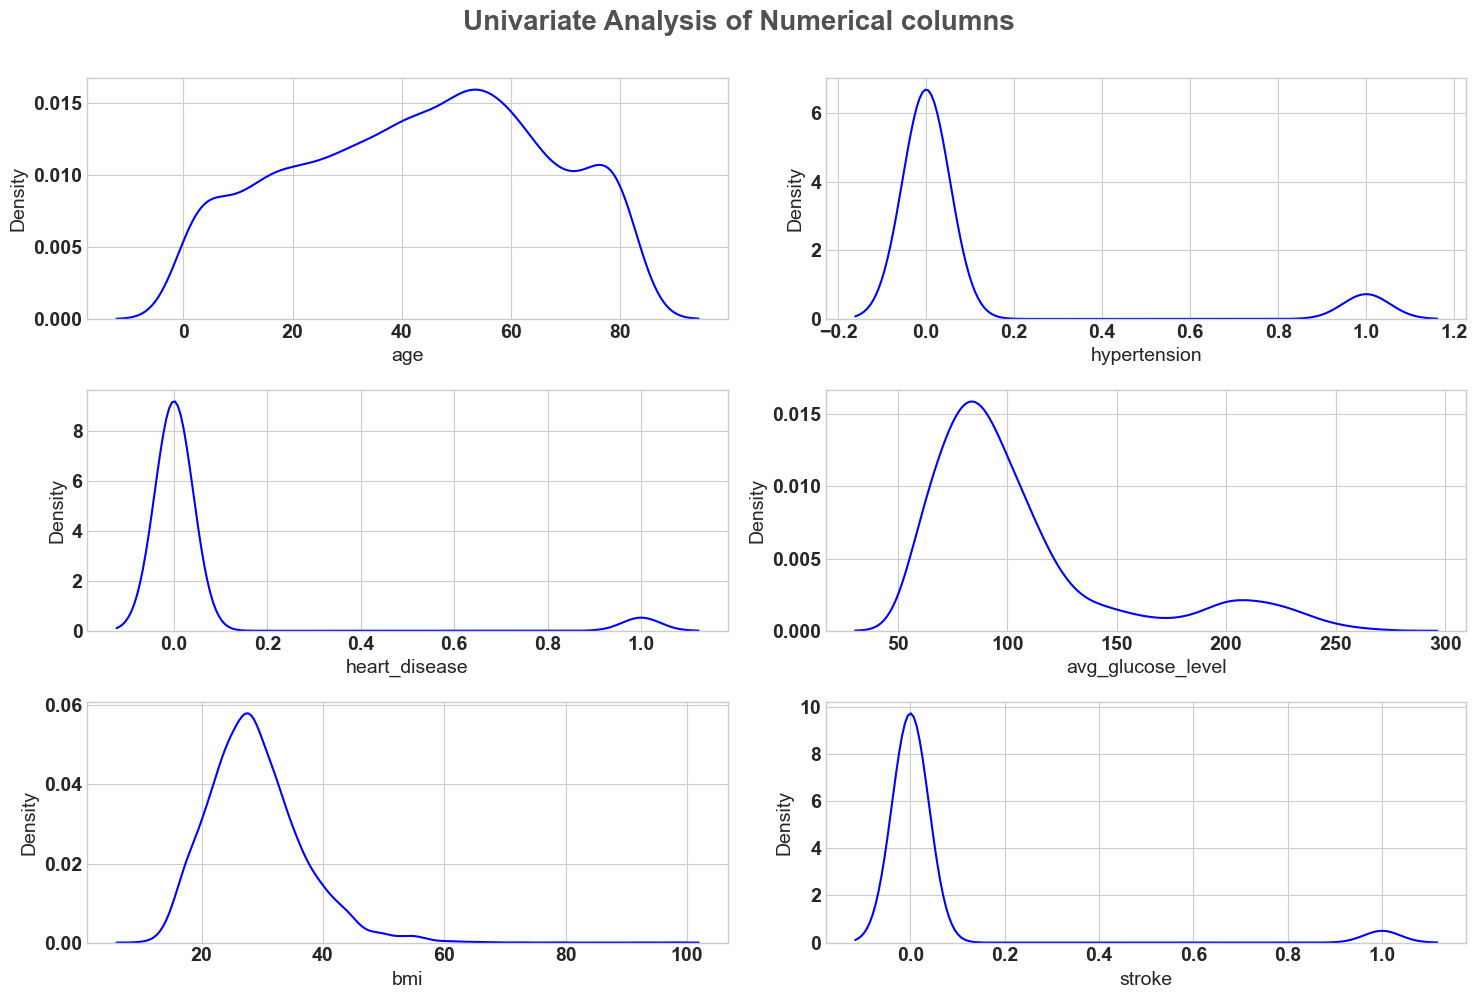

In [12]:
plt.figure(figsize=(15,10))
plt.suptitle("Univariate Analysis of Numerical columns", 
             fontsize = 20,
             fontweight = "bold",
             alpha = .8,
             y= 1)
for i, col in enumerate(num_cols):
    plt.subplot(3,2, i+1)
    sns.kdeplot(x = df[col], color = 'blue')
    plt.tight_layout()

In [13]:
cat_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [14]:
df['stroke'].unique()

array([1, 0])

## Univariate Analysis of Categorical columns

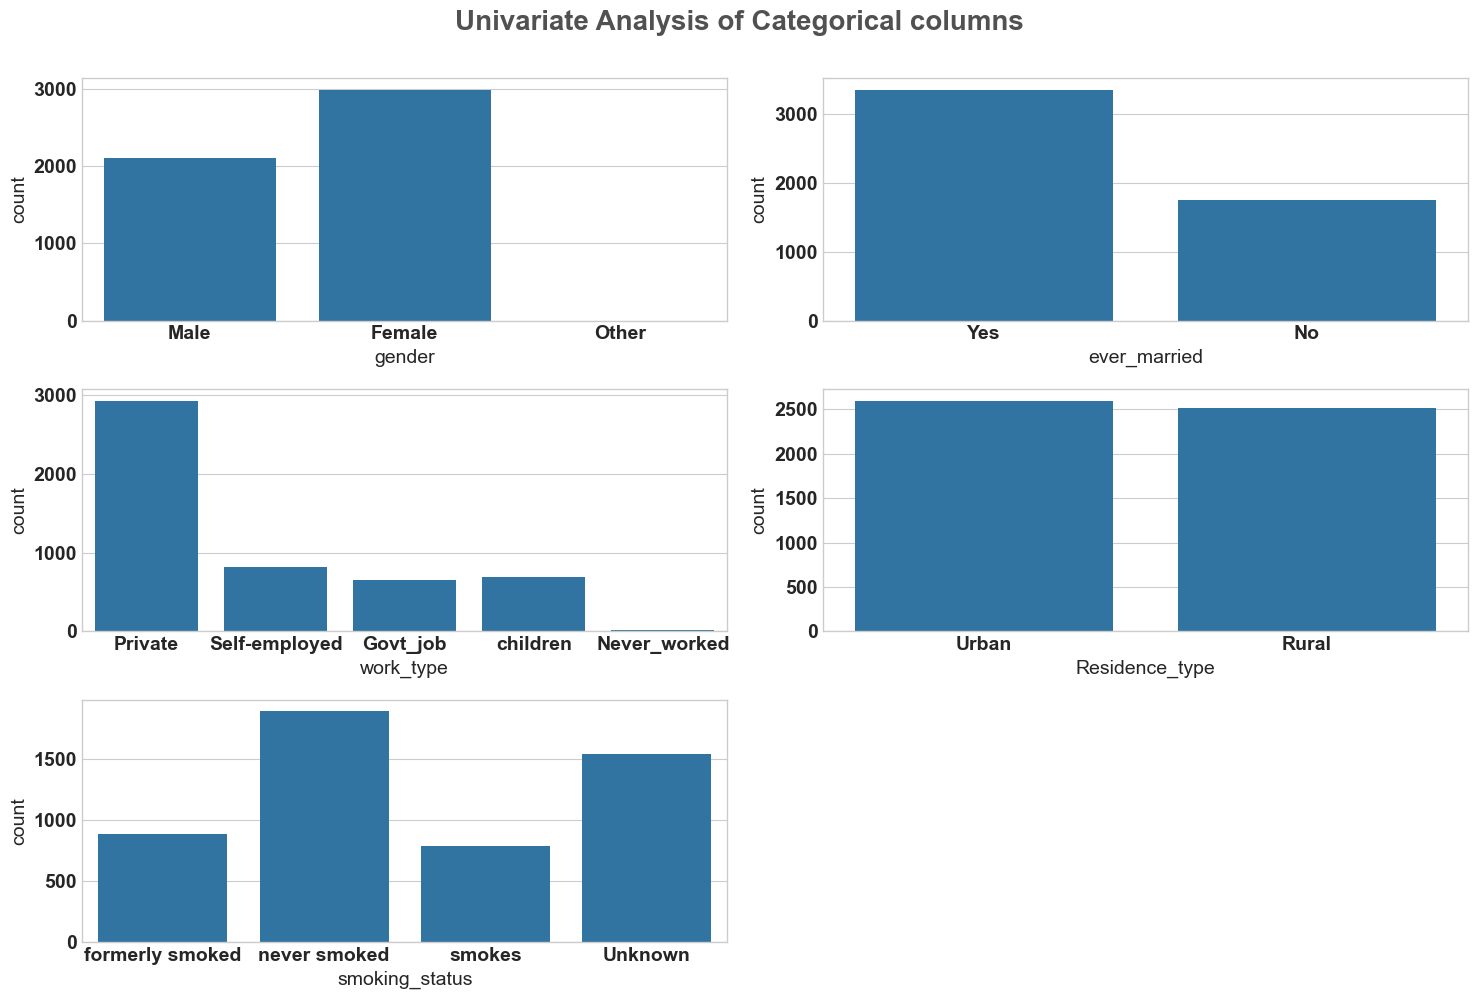

In [15]:
plt.figure(figsize=(15,10))
plt.suptitle("Univariate Analysis of Categorical columns", 
             fontsize = 20,
             fontweight = "bold",
             alpha = .8,
             y= 1)

for i,col in enumerate(cat_cols):
    plt.subplot(3,2,i+1)
    sns.countplot(x = df[col])
    plt.tight_layout()

## Multivariate Analysis

In [16]:
discrete_cols, continous_cols, encoded_cols = [],[],[]

for col in num_cols:
    if df[col].nunique()<=25 and df[col].nunique()>5:
        discrete_cols.append(col)
    elif df[col].nunique()>25:
        continous_cols.append(col)
    elif df[col].nunique()<=5:
        encoded_cols.append(col)

print(f"discrete_cols: {discrete_cols}")
print(f"continous_cols: {continous_cols}")
print(f"encoded_cols: {encoded_cols}")

discrete_cols: []
continous_cols: ['age', 'avg_glucose_level', 'bmi']
encoded_cols: ['hypertension', 'heart_disease', 'stroke']


- Considering encoded_cols as Categorical columns

In [17]:
cat_cols=encoded_cols+list(cat_cols)
cat_cols

['hypertension',
 'heart_disease',
 'stroke',
 'gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

Check multicollinearity in Numerical Features

In [18]:
df[continous_cols].corr()

,age,avg_glucose_level,bmi
age,1.000000,0.238171,0.333398
avg_glucose_level,0.238171,1.000000,0.175502
bmi,0.333398,0.175502,1.000000


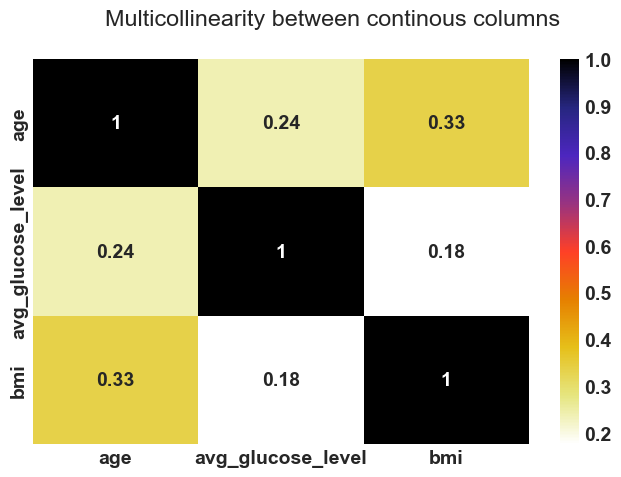

In [19]:
plt.suptitle("Multicollinearity between continous columns")
sns.heatmap(df[continous_cols].corr(),cmap="CMRmap_r", annot= True)
plt.show()

- There is no Multicollinearity between columns since, there is no correlation

Check multicollinearity in Categorical Features

    - Chi-Square test: to check relationship between 2 categorical columns
    - Perform test between Categorical Features and target column

Null Hypothesis H0: The feature is idependent of target column(No-Correlation)

Alternative Hypothesis H1: The feature & target column are not idependent (Correlation)

In [20]:
chi2_test, p_values = [],[]
for col in cat_cols:
    if (p_value:= chi2_contingency(pd.crosstab(df['stroke'], df[col]))[1])<0.05:
        p_values.append(p_value)
        chi2_test.append("Reject Null Hypothesis")
    else:
        p_values.append(p_value)
        chi2_test.append("Failed to Reject Null Hypothesis")

pd.DataFrame(data={'Columns': cat_cols,"p_values":p_values, 'Result':chi2_test})

,Columns,p_values,Result
0,hypertension,1.661622e-19,Reject Null Hypothesis
1,heart_disease,2.088785e-21,Reject Null Hypothesis
2,stroke,0.000000e+00,Reject Null Hypothesis
3,gender,7.895491e-01,Failed to Reject Null Hypothesis
4,ever_married,1.638902e-14,Reject Null Hypothesis
5,work_type,5.397708e-10,Reject Null Hypothesis
6,Residence_type,2.983317e-01,Failed to Reject Null Hypothesis
7,smoking_status,2.085400e-06,Reject Null Hypothesis


In [21]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [22]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Impute the missing values in 'bmi' column

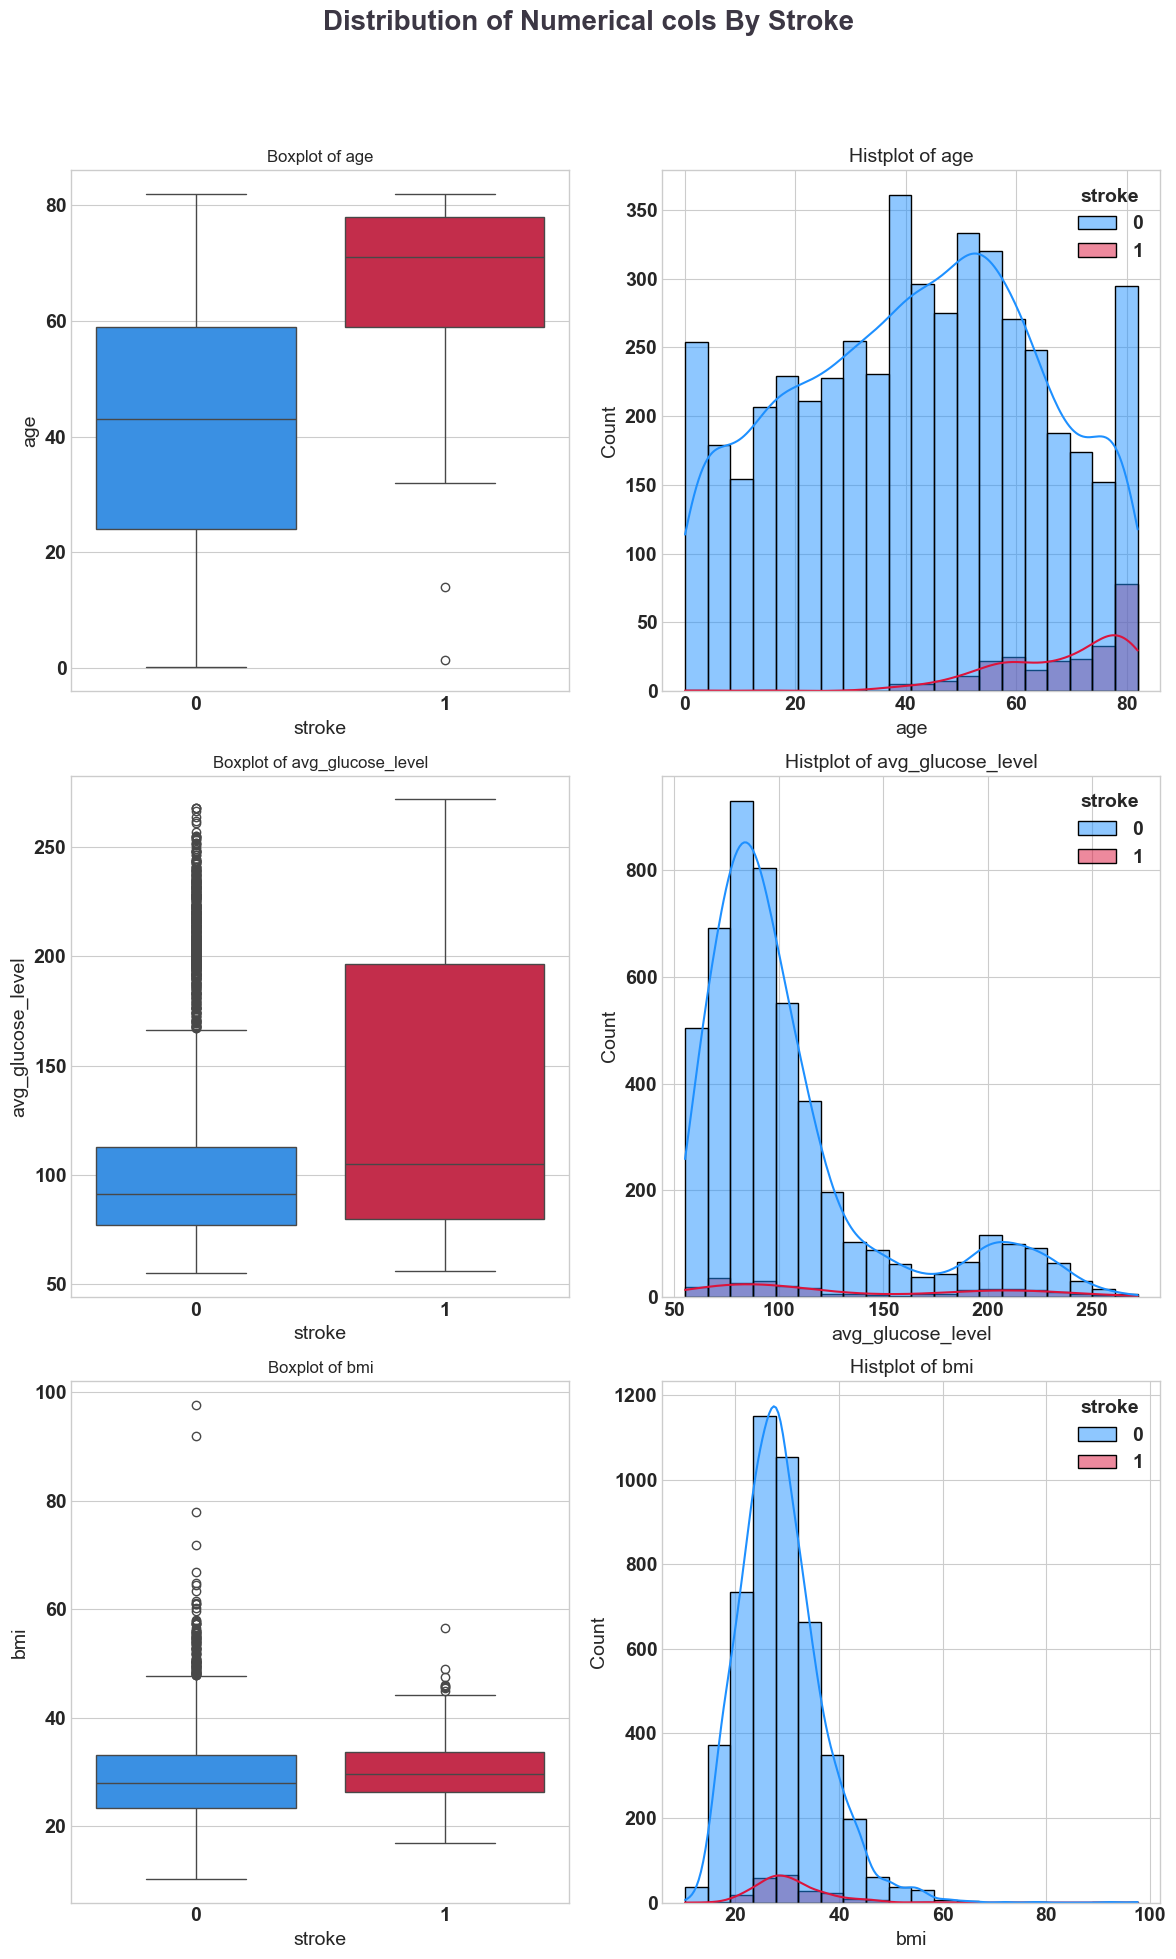

In [23]:
clr1 =['#1E90FF', '#DC143C']
fig,ax = plt.subplots(3,2, figsize=(12,20))
fig.suptitle("Distribution of Numerical cols By Stroke", color = "#3C3744",
             fontsize = 20, fontweight= 'bold', ha = 'center')
for i,col in enumerate(continous_cols): 
    sns.boxplot(data= df, x = "stroke", y =col, palette=clr1, ax= ax[i,0])
    ax[i,0].set_title(f"Boxplot of {col}", fontsize =12)
    sns.histplot(data=df, x = col, hue = "stroke", bins = 20, kde = True, palette=clr1, ax = ax[i,1])
    ax[i,1].set_title(f"Histplot of {col}", fontsize =14)

fig.tight_layout()
fig.subplots_adjust(top=.9)    

Insights:

- from age 40 onwards the chances of herat stroke is increasing.
- It is high for the people who are above 60 yrs old. 
- for the people if the avg_glucose_level is high the chances of heart stroke is high.
- bmi is not much influence on the heart stroke

## Visualisation

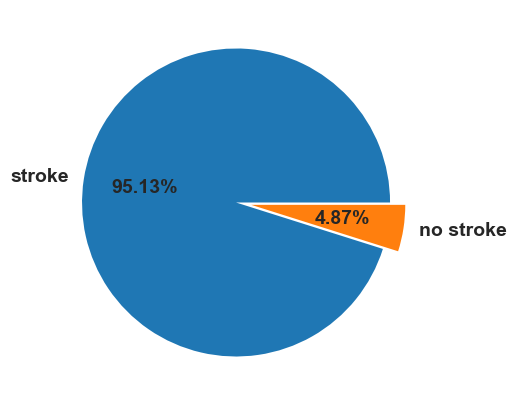

In [24]:
df1 = df.copy()

df1['stroke'] = np.where((df.stroke ==1), "stroke", "no stroke")

stroke_percentage = df1['stroke'].value_counts(normalize=True)*100

plt.pie(x = stroke_percentage,
        labels= ["stroke", "no stroke"],
        autopct='%.2f%%',
         explode = [0,.1])
plt.show()

- Here the 95% are non-stroke people i.e, it is imbalance dataset.

Do men or women have more chance of stroke?

In [25]:
df1[df1['stroke'] == "stroke"].gender.value_counts(normalize=True)*100

gender
Female    56.626506
Male      43.373494
Name: proportion, dtype: float64

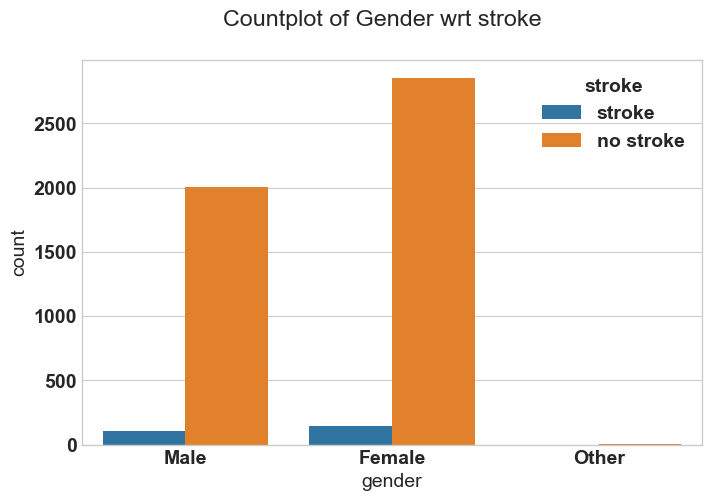

In [26]:
sns.countplot(data= df1, x = 'gender', hue= 'stroke')
plt.suptitle("Countplot of Gender wrt stroke")
plt.show()

- No major effect of heart stroke based on gender
- Hence, Above the chisquare test also proves that gender is not dependent on the target column

Age Split

In [27]:
bins = [0,10,20,50,85]
labels = ['Children', 'Teens', 'Adult', 'Senior']
df1['age_cat'] = pd.cut(df1['age'], bins=bins, labels=labels, right= False)
df1.groupby(["age_cat", "stroke"]).size().reset_index(name = 'count')

,age_cat,stroke,count
0,Children,no stroke,471
1,Children,stroke,1
2,Teens,no stroke,493
3,Teens,stroke,1
4,Adult,no stroke,1916
5,Adult,stroke,18
6,Senior,no stroke,1981
7,Senior,stroke,229


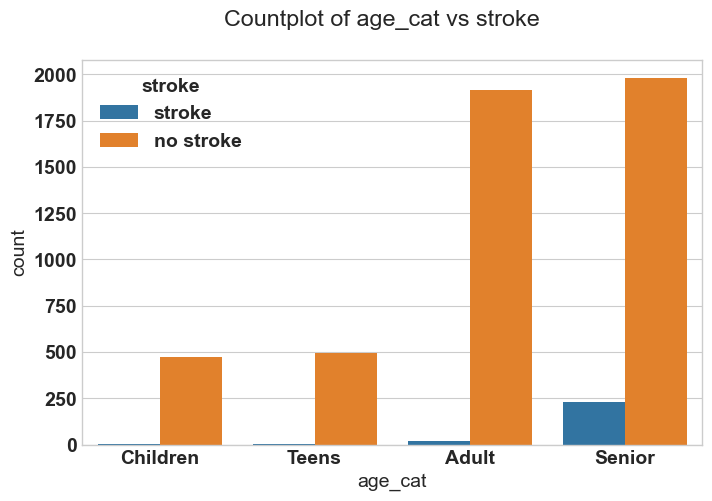

In [28]:
sns.countplot(data = df1, x = "age_cat", hue = "stroke")
plt.suptitle("Countplot of age_cat vs stroke")
plt.show()

- People who are senior are more prone to heart strokes than children or teens

In [29]:
bins = [0,10,20,30,40,50,60,70,80,90]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90']
df1['age_grp'] = pd.cut(df1['age'], bins = bins, labels = labels)

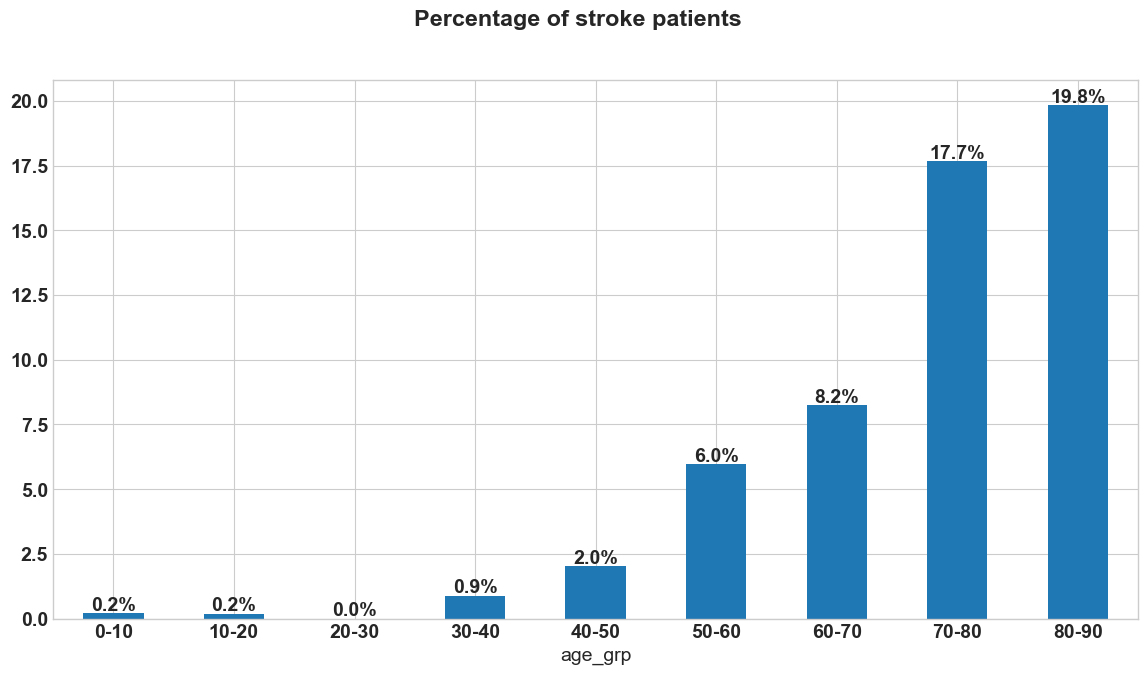

In [30]:
age_grp_pcntge = (df1[df1['stroke'].isin(["stroke"])]['age_grp'].value_counts()/df1['age_grp'].value_counts())*100
plt.figure(figsize=[14,7])
age_grp_pcntge.plot(kind = "bar")
for i in range(age_grp_pcntge.shape[0]):
    count = age_grp_pcntge[i]
    strt= "{:0.1f}%".format(count)
    plt.text(i, count+0.1, strt, ha= 'center')
    
plt.suptitle("Percentage of stroke patients",fontweight = "bold")
plt.xticks(rotation =0)
plt.show()

## Does Hypertension makes any difference?

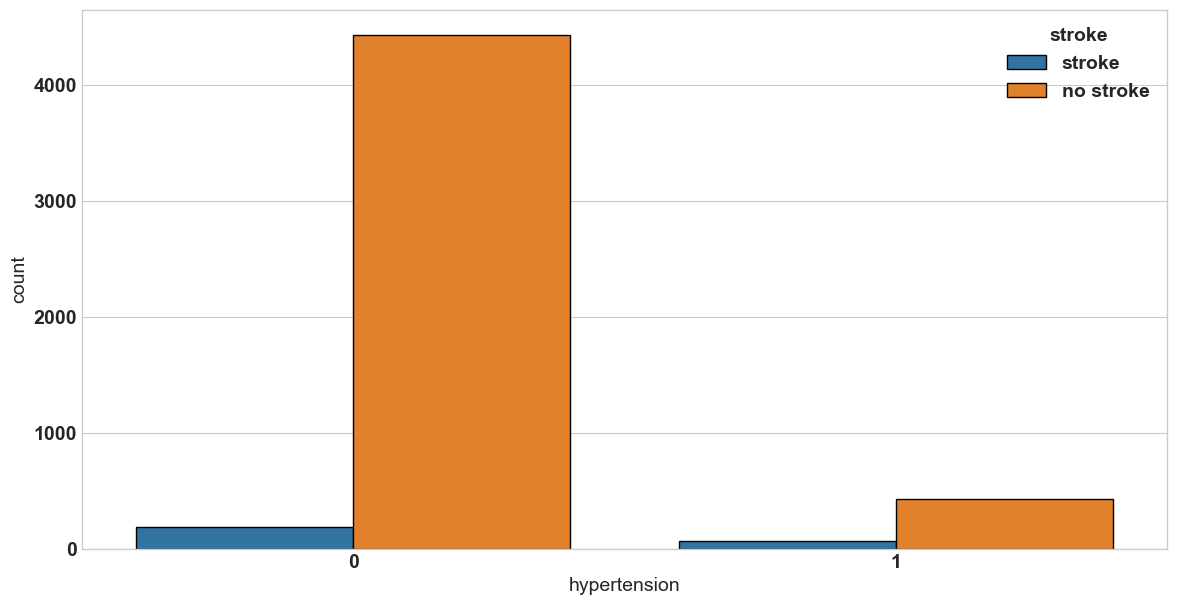

In [31]:
plt.figure(figsize = (14,7))
sns.countplot(data=df1, x = "hypertension", hue="stroke", ec = "black")
plt.show()

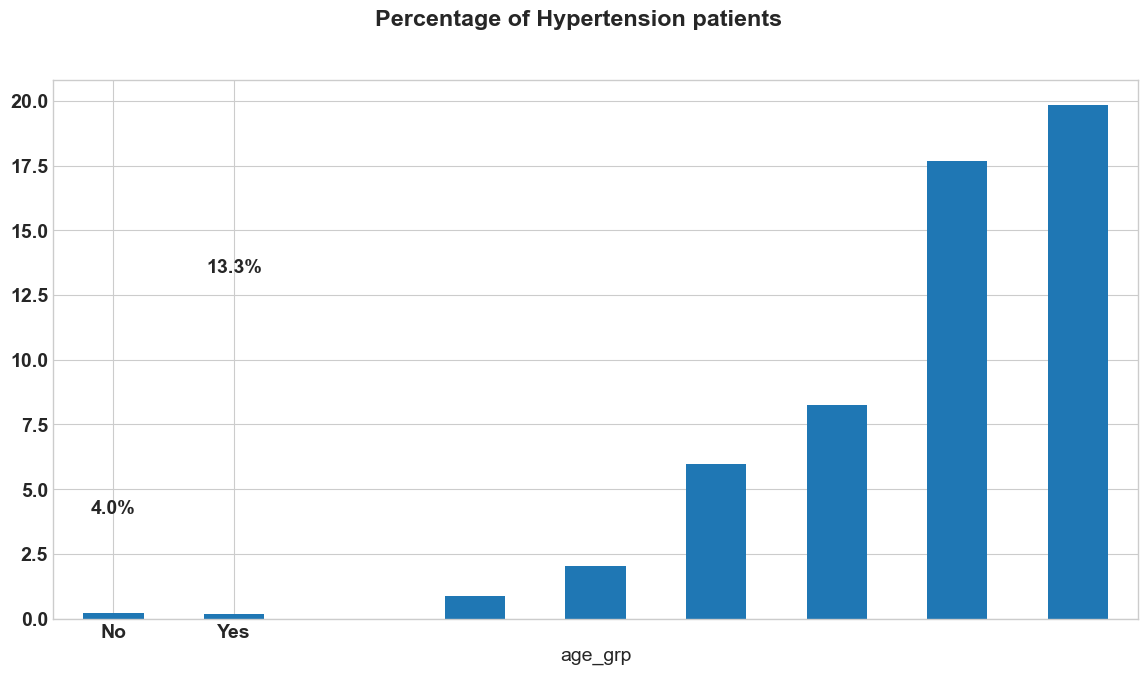

In [32]:
hyper_grp_pcntge = (df1[df1['stroke'].isin(["stroke"])]['hypertension'].value_counts()/df1['hypertension'].value_counts())*100
plt.figure(figsize=[14,7])
age_grp_pcntge.plot(kind = "bar")
for i in range(hyper_grp_pcntge.shape[0]):
    count = hyper_grp_pcntge[i]
    strt= "{:0.1f}%".format(count)
    plt.text(i, count+0.1, strt, ha= 'center')
    
plt.suptitle("Percentage of Hypertension patients",fontweight = "bold")
plt.xticks(rotation =0, ticks= [0,1], labels = ['No', 'Yes'])
plt.show()

- Persons with Hypertension has more heart strokes

## Impact of BMI

- BMI parameter can be divided into 4 categories 
    - under_weight(BMI<18.5)
    - normal_weight(18.5<BMI<25)
    - over_weight(25<BMI<30)
    - obese(BMI>30)

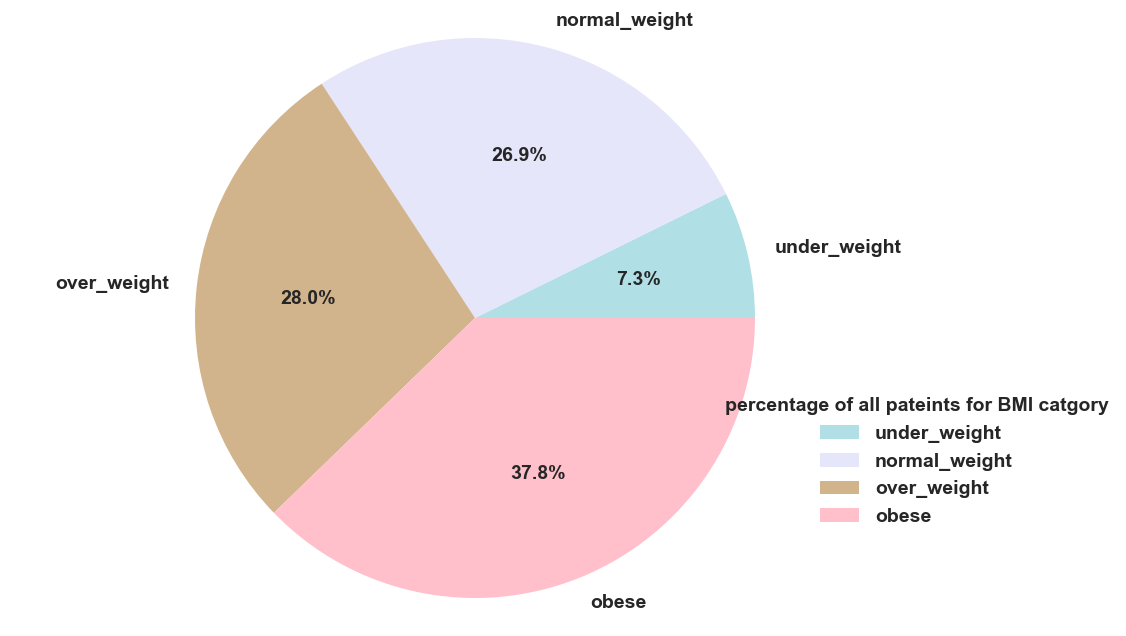

In [34]:
fig,ax = plt.subplots(figsize= (12,8))
bmi_x_vals = [df[df['bmi']<=18.5]['stroke'].value_counts()[0],
                df[(df['bmi']<=25)&(df['bmi']>18)]['stroke'].value_counts()[0],
                df[(df['bmi']<=30)&(df['bmi']>25)]['stroke'].value_counts()[0],
                df[df['bmi']>30]['stroke'].value_counts()[0]]
ax.pie(x = bmi_x_vals, labels= ['under_weight', 'normal_weight', 'over_weight', 'obese'],
       autopct = "%1.1f%%", colors = ['powderblue', 'lavender', 'tan', 'pink'])

ax.axis('equal')
plt.legend(title = "percentage of all pateints for BMI catgory",
           loc = 1, bbox_to_anchor=(1.2,.4))
plt.show()

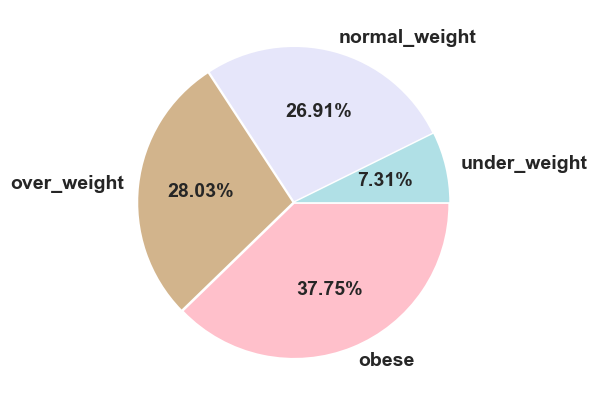

In [35]:
plt.pie(x = bmi_x_vals,
        labels= ['under_weight', 'normal_weight', 'over_weight', 'obese'],
        autopct='%.2f%%',
        colors = ['powderblue', 'lavender', 'tan', 'pink'],
        explode = [.01,.01,.01,.01])

plt.show()

In [36]:
bins = [0,18, 25, 30, 100]
labels = ['0-18', '18-25', '25-30', '30-100']
df1['bmi_cat'] = pd.cut(df1['bmi'], bins= bins, labels = labels)


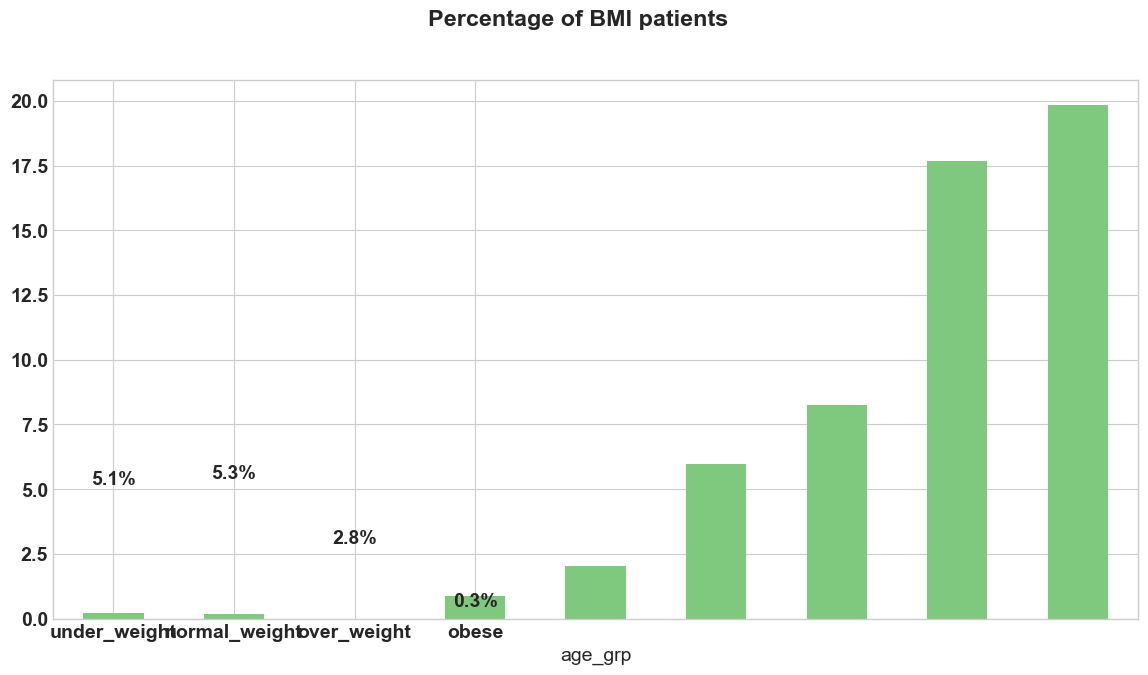

In [37]:
bmi_grp_pcntge = (df1[df1['stroke'].isin(["stroke"])]['bmi_cat'].value_counts()/df1['bmi_cat'].value_counts())*100
plt.figure(figsize=(14,7))
age_grp_pcntge.plot(kind = "bar", stacked = True, colormap='Accent')
for i in range(bmi_grp_pcntge.shape[0]):
    count = bmi_grp_pcntge[i]
    strt= "{:0.1f}%".format(count)
    plt.text(i, count+0.1, strt, ha= 'center')
    
plt.suptitle("Percentage of BMI patients",fontweight = "bold")
plt.xticks(rotation =0, ticks= [0,1,2,3], labels = ['under_weight', 'normal_weight', 'over_weight', 'obese'])
plt.show()

## heart disease vs stroke

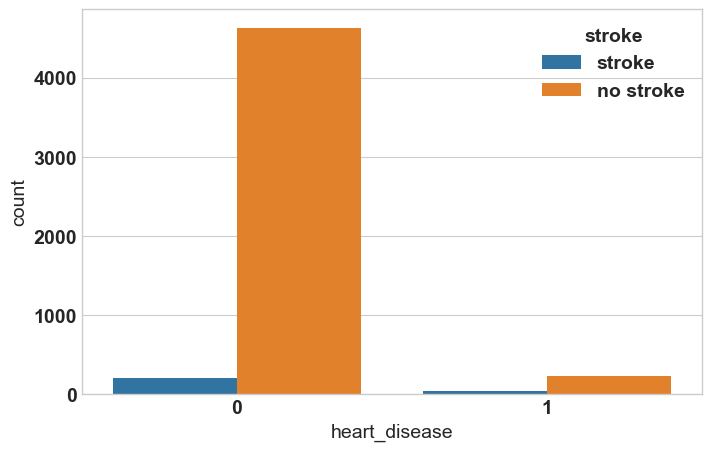

In [38]:
sns.countplot(data = df1 ,
              x = 'heart_disease', 
              hue = 'stroke')
plt.show()

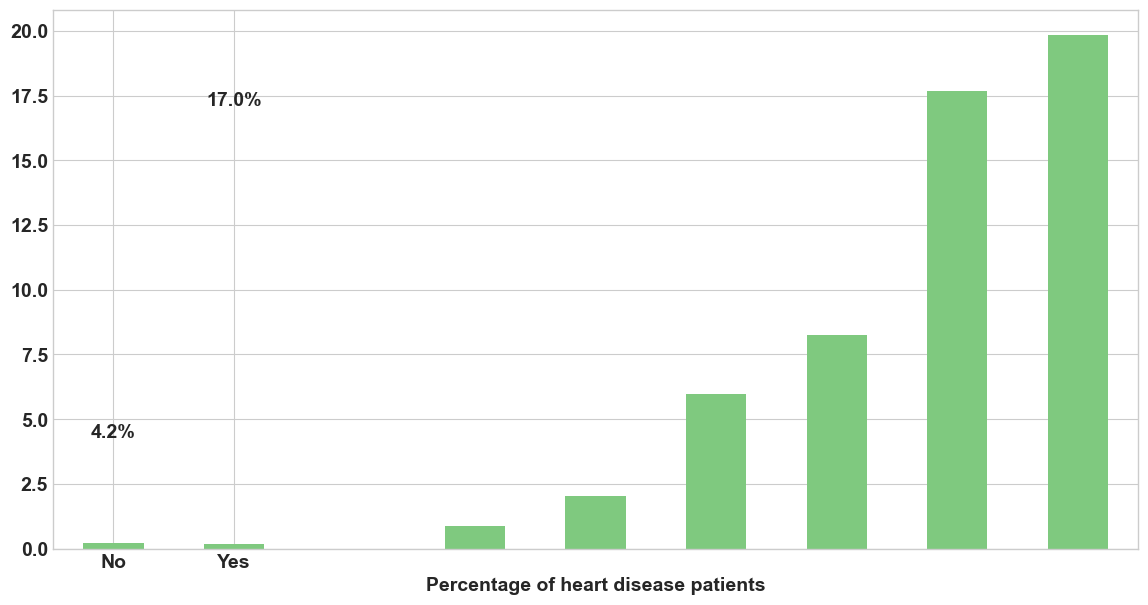

In [39]:
bmi_grp_pcntge = (df1[df1['stroke'].isin(["stroke"])]['heart_disease'].value_counts()/df1['heart_disease'].value_counts())*100
plt.figure(figsize=(14,7))
age_grp_pcntge.plot(kind = "bar", stacked = True, colormap='Accent')
for i in range(bmi_grp_pcntge.shape[0]):
    count = bmi_grp_pcntge[i]
    strt= "{:0.1f}%".format(count)
    plt.text(i, count+0.1, strt, ha= 'center')
    
plt.xlabel("Percentage of heart disease patients",fontweight = "bold")
plt.xticks(rotation =0, ticks= [0,1], labels = ['No', 'Yes'])
plt.show()

posx and posy should be finite values
posx and posy should be finite values


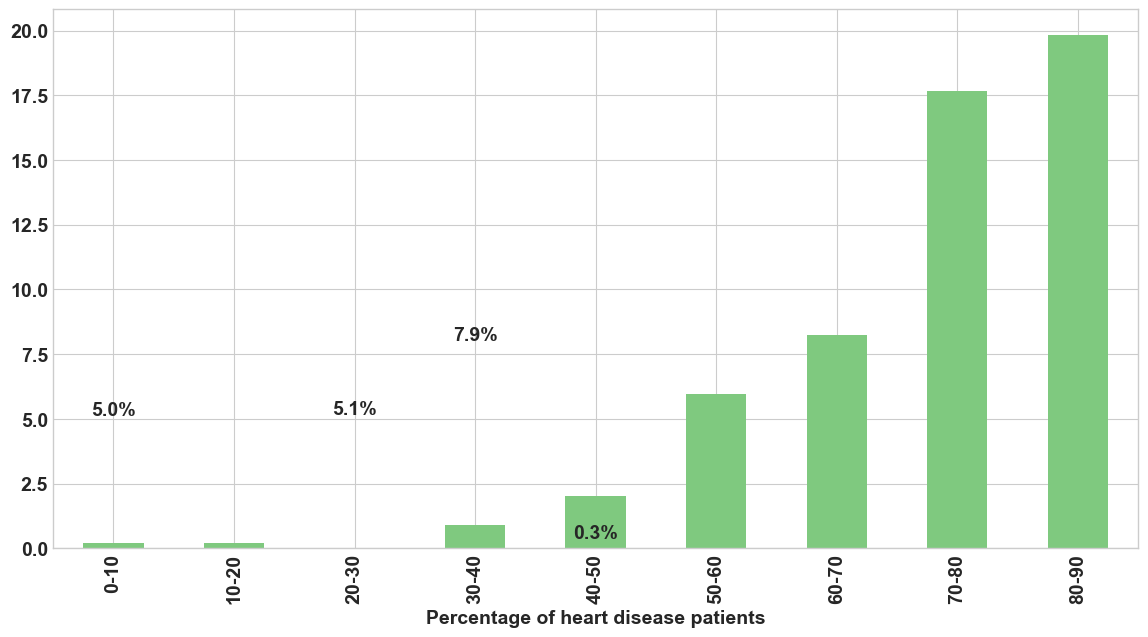

In [40]:
bmi_grp_pcntge = (df1[df1['stroke'].isin(["stroke"])]['work_type'].value_counts()/df1['work_type'].value_counts())*100
plt.figure(figsize=(14,7))
age_grp_pcntge.plot(kind = "bar", stacked = True, colormap='Accent')
for i in range(bmi_grp_pcntge.shape[0]):
    count = bmi_grp_pcntge[i]
    strt= "{:0.1f}%".format(count)
    plt.text(i, count+0.1, strt, ha= 'center')
    
plt.xlabel("Percentage of heart disease patients",fontweight = "bold")
# plt.xticks(rotation =0, ticks= [0,1], labels = ['No', 'Yes'])
plt.show()

Imputing BMI values

In [67]:
df1['bmi'].fillna(df1['bmi'].median(), inplace = True)
df['bmi'].fillna(df['bmi'].median(), inplace = True)

Multicollinearity check

Variance Inflation Factor (VIF)

In [43]:
df1.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
age_cat                0
age_grp                0
bmi_cat              201
dtype: int64

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(features, df):
    x = df[features]
    x['intercept'] = 1 #the calculation of VIF requires a const

    vif = pd.DataFrame()
    vif['variable'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif = vif[vif['variable']!='intercept']
    return vif

In [46]:
compute_vif(continous_cols, df1)

,variable,VIF
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


checking for outliers

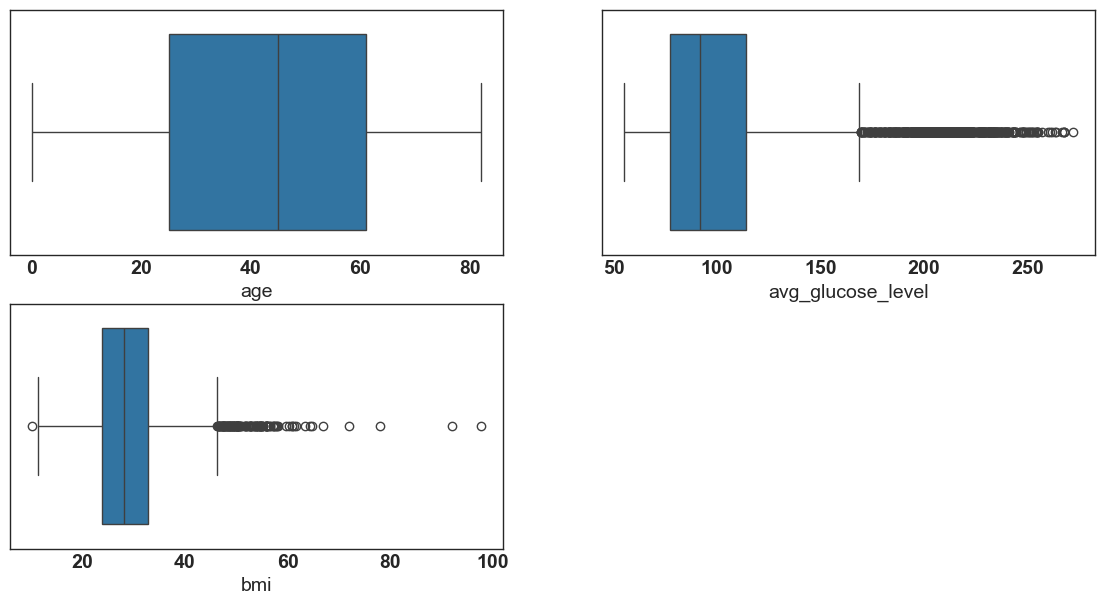

In [70]:
plt.figure(figsize=(14,7))
for i,col in enumerate(continous_cols):
    plt.subplot(2,2,i+1)
    sns.set_style('ticks')
    sns.boxplot(data = df1, x = col, orient='y')

Standard deviation Method for outlier handling

In [87]:
def outlier_removal(df, col):
    ul = df[col].mean() + 3*df[col].std()
    ll = df[col].mean() - 3*df[col].std()
    df = df[(df[col]<ul)&(df[col]>ll)]
    return df

In [90]:
df = outlier_removal(df, 'bmi')

<Axes: xlabel='bmi'>

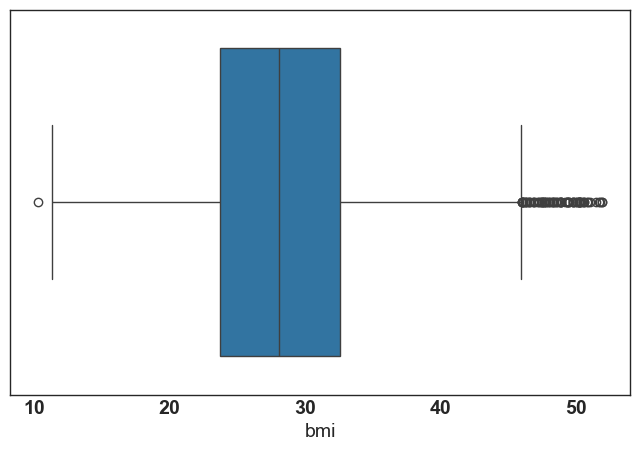

In [91]:
sns.boxplot(x = df['bmi'])

Feature Transformation

In [92]:
df[continous_cols].skew(axis=0)

age                 -0.134358
avg_glucose_level    1.583938
bmi                  0.479761
dtype: float64

Model building

In [93]:
from sklearn.model_selection import train_test_split

X = df.drop(['stroke'], axis = 1)
y = df['stroke']

In [95]:
for col in cat_cols:
    print(col, ":", df[col].nunique())

hypertension : 2
heart_disease : 2
stroke : 2
gender : 3
ever_married : 2
work_type : 5
Residence_type : 2
smoking_status : 4


Feature Encoding and scaling

One hot encoding is for columns which has lesser unique values & not ordinal

In [98]:
for i in continous_cols:
    print(f'{i} : mean = {df[i].mean():.2f}, median = {df[i].median():.2f}')

age : mean = 43.20, median = 45.00
avg_glucose_level : mean = 105.96, median = 91.85
bmi : mean = 28.52, median = 28.10


In [96]:
continous_cols

['age', 'avg_glucose_level', 'bmi']

In [108]:
#create column transformer with 3 types of transformers

cat_features = X.select_dtypes(include='object').columns
num_features = list(num_cols).copy()
num_features.remove('stroke')
transform_features = ['avg_glucose_level']

In [107]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [112]:
numeric_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps = [
    ('one_hot_encoder', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean = False))
])

transform_pipe = Pipeline(steps = [
    ('transformer', PowerTransformer(standardize = True))
])

prepocessor = ColumnTransformer([
    ("numeric_pipeline", numeric_pipeline, num_features),
    ("categorical_pipeline",categorical_pipeline, cat_features ),
    ("power_transformation", transform_pipe, transform_features)
])

In [113]:
X = prepocessor.fit_transform(X)

In [114]:
from imblearn.combine import SMOTETomek, SMOTEENN

#resampling the minority class. The strategy can be chnaged as required.
smt = SMOTEENN(random_state= 42, sampling_strategy = 'minority')

#fit the model to generate the data.
X_res, y_res = smt.fit_resample(X,y)

## Model Selection

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             ConfusionMatrixDisplay,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve)

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [119]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1= f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, roc_auc

In [120]:
#initialize models which are reuqired for models
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(), 
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier()
}

In [144]:
#create a function which can be evoluate models and return a report

def evaluate_models(X,y, models):

    X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=.2, random_state=42)
    models_list, accuracy_list, auc = [],[],[]

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) #train model

        #make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        #training set performance
        model_train_accuracy, model_train_f1, model_train_precision,\
             model_train_recall, model_train_rocauc_score =evaluate_clf(y_train, y_train_pred)
        
        # test set performance
        model_test_accuracy, model_test_f1, model_test_precision,\
             model_test_recall, model_test_rocauc_score =evaluate_clf(y_test, y_test_pred)
        
        models_list.append(list(models.keys())[i])

        print(list(models.keys())[i])
        print("Model performance for training set: ")
        print(f"Accuracy: {model_train_accuracy:.4f}")
        print(f"F1_score: {model_train_f1:.4f}")
        print(f"Precision: {model_train_precision:.4f}")
        print(f"Recall: {model_train_recall:.4f}")
        print(f"ROC_AUC: {model_train_rocauc_score:.4f}")
        print("-"*90)
        print("Model performance for testing set: ")
        print(f"Accuracy: {model_test_accuracy:.4f}")
        accuracy_list.append(model_test_accuracy)
        print(f"F1_score: {model_test_f1:.4f}")
        print(f"Precision: {model_test_precision:.4f}")
        print(f"Recall: {model_test_recall:.4f}")
        print(f"ROC_AUC: {model_test_rocauc_score:.4f}")
        auc.append(model_test_rocauc_score)
        print("="*90)
        
#     report = pd.DataFrame(list(zip(models_list, accuracy_list)), 
#                           columns=['Model Name', "Accuracy"]).sort_values(by=['Accuracy'], axis=1)
    
    return None

Evaluate all base models

In [145]:
base_report = evaluate_models(X=X_res,y=y_res, models = models)

DecisionTreeClassifier
Model performance for training set: 
Accuracy: 1.0000
F1_score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC_AUC: 1.0000
------------------------------------------------------------------------------------------
Model performance for testing set: 
Accuracy: 0.9029
F1_score: 0.9104
Precision: 0.9074
Recall: 0.9134
ROC_AUC: 0.9020
RandomForestClassifier
Model performance for training set: 
Accuracy: 1.0000
F1_score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC_AUC: 1.0000
------------------------------------------------------------------------------------------
Model performance for testing set: 
Accuracy: 0.9736
F1_score: 0.9758
Precision: 0.9663
Recall: 0.9856
ROC_AUC: 0.9726
GradientBoostingClassifier
Model performance for training set: 
Accuracy: 0.9306
F1_score: 0.9364
Precision: 0.9145
Recall: 0.9595
ROC_AUC: 0.9285
------------------------------------------------------------------------------------------
Model performance for testing set: 
Accuracy: 0.9173
F1_

here we can use RandomForestClassifier, XGBClassifier, Catboost Classifier, KNeighborsClassifier for hyper parameter tuning

In [161]:
#initialize few parameters for hyperparameter tuning
xgboost_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth":[5,8,12,20,30],
    "n_estimators":[100, 200, 300],
    "colsample_bylevel":[0.5, 0.8, 1, 0.3, 0.4]
}

cat_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [10, 15, 20, 30]
}

rf_params = {
    "max_depth": [10, 12, None, 15],
    "max_features": ['sqrt', 'log2', None],
    "min_samples_split": [100, 150, 200, 300],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', "kd_tree", "brute"],
    "weights": ["uniform", "distance"],
    "n_neighbors":[3,4,5,7,9]
}

In [162]:
#models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(n_jobs=1), xgboost_params), # Use n_jobs=1 for XGBoost to avoid pickling issues
    ('RF', RandomForestClassifier(), rf_params),
    ('KNN', KNeighborsClassifier(), knn_params)
]

In [164]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}

for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator= model,
                                param_distributions=params,
                                n_iter = 100,
                                cv = 3,
                                verbose = 2,
                                n_jobs =1)
    
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_


for model_name in model_param:
    print(f"best params for {model_name}")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bylevel=0.4, learning_rate=0.01, max_depth=8, n_estimators=200; total time=   0.8s
[CV] END colsample_bylevel=0.4, learning_rate=0.01, max_depth=8, n_estimators=200; total time=   1.0s
[CV] END colsample_bylevel=0.4, learning_rate=0.01, max_depth=8, n_estimators=200; total time=   1.3s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=20, n_estimators=300; total time=   2.2s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=20, n_estimators=300; total time=   2.8s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=20, n_estimators=300; total time=   3.3s
[CV] END colsample_bylevel=0.3, learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END colsample_bylevel=0.3, learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END colsample_bylevel=0.3, learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END colsample_byl

### outcome
best params for XGBoost
{'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bylevel': 0.3}

best params for RF
{'n_estimators': 10, 'min_samples_split': 100, 'max_features': 'log2', 'max_depth': 15}

best params for KNN
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}

## Retraining te model with the Best parameters

In [167]:
from sklearn.metrics import roc_auc_score, roc_curve

best_models = {
    "RF classifier" : RandomForestClassifier(**model_param['RF']),
    "KNN classifier" : KNeighborsClassifier(**model_param['KNN']),
    "XGBoost classifier" : XGBClassifier(**model_param['XGBoost'])
}

tuned_report = evaluate_models(X=X_res, y=y_res, models=best_models)

tuned_report

RF classifier
Model performance for training set: 
Accuracy: 0.9100
F1_score: 0.9183
Precision: 0.8897
Recall: 0.9488
ROC_AUC: 0.9073
------------------------------------------------------------------------------------------
Model performance for testing set: 
Accuracy: 0.8939
F1_score: 0.9045
Precision: 0.8803
Recall: 0.9301
ROC_AUC: 0.8907
KNN classifier
Model performance for training set: 
Accuracy: 1.0000
F1_score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC_AUC: 1.0000
------------------------------------------------------------------------------------------
Model performance for testing set: 
Accuracy: 0.9880
F1_score: 0.9890
Precision: 0.9783
Recall: 1.0000
ROC_AUC: 0.9870
XGBoost classifier
Model performance for training set: 
Accuracy: 1.0000
F1_score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC_AUC: 1.0000
------------------------------------------------------------------------------------------
Model performance for testing set: 
Accuracy: 0.9790
F1_score: 0.9807
Precision: 

In [168]:
tuned_report

## Plot Roc Auc Curve

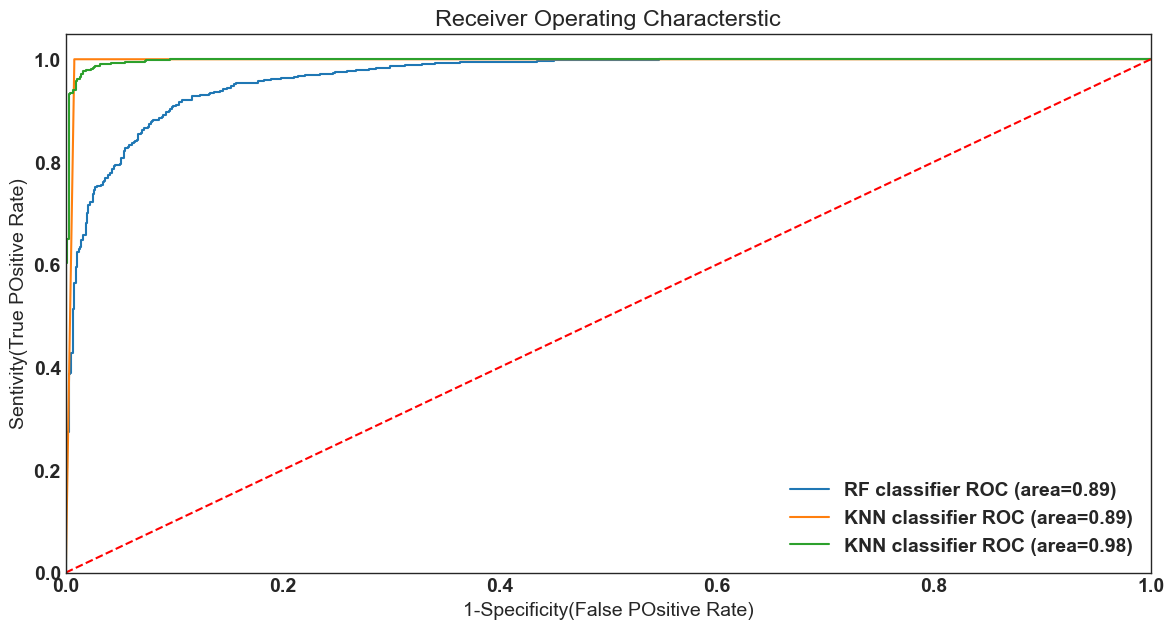

In [172]:
from sklearn.metrics import roc_auc_score, roc_curve

#add the models to the list that you want to view on the ROC plot
auc_models=[
  { 
      'label':"RF classifier",
      'model': RandomForestClassifier(**model_param['RF']),
      'auc': 0.8939
   },
   { 
      'label':"KNN classifier",
      'model': KNeighborsClassifier(**model_param['KNN']),
      'auc': 0.8939
   },
   { 
      'label':"KNN classifier",
      'model': XGBClassifier(**model_param['XGBoost']),
      'auc': 0.9790
   }
]


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

#create loop through all model

plt.figure(figsize=(14,7))
for algo in auc_models:
    model = algo['model'] #select the model
    model.fit(X_train, y_train) #train the model

   #compute False positive rate & True Positive rate
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

   #calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label = '%s ROC (area=%0.2f)' % (algo['label'], algo['auc']))


#custom settings for the plot
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False POsitive Rate)')
plt.ylabel('Sentivity(True POsitive Rate)')
plt.title('Receiver Operating Characterstic')
plt.legend(loc = "lower right")
plt.show()

- KNN classifier performs the best

## Final Report

In [174]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("FINAL MODEL 'KNN'")
print(f"Accuracy Score Value:{score:.4f}")
print(cr)

FINAL MODEL 'KNN'
Accuracy Score Value:0.9880
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       767
           1       0.98      1.00      0.99       901

    accuracy                           0.99      1668
   macro avg       0.99      0.99      0.99      1668
weighted avg       0.99      0.99      0.99      1668



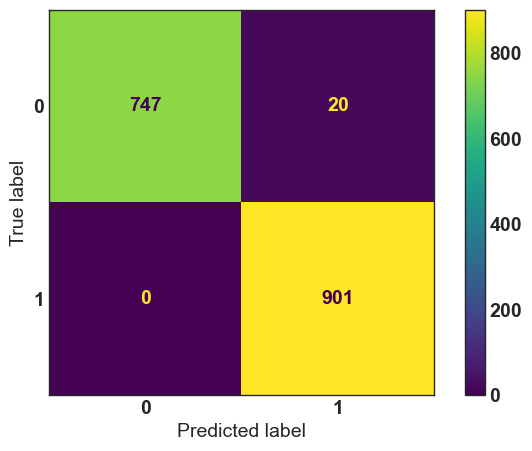

In [175]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [178]:
from sklearn.model_selection import cross_val_score

for name, model in best_models.items():
    scores = cross_val_score(model, X_res, y_res, cv=5)
    print(f"{name} cross-validation scores: {scores}")
    print(f"Mean {name} cross-validation scores: {scores.mean()}")
    print("="*90)


RF classifier cross-validation scores: [0.87889688 0.89862028 0.89682064 0.90881824 0.91421716]
Mean RF classifier cross-validation scores: 0.8994746374466114
KNN classifier cross-validation scores: [0.98980815 0.98380324 0.9880024  0.9880024  0.98920216]
Mean KNN classifier cross-validation scores: 0.9877636702875252
XGBoost classifier cross-validation scores: [0.96342926 0.98020396 0.97480504 0.97420516 0.97960408]
Mean XGBoost classifier cross-validation scores: 0.9744494985894908


# ---> KNN is BEST model <---